In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_seed(1234)

keras = tf.keras

from numpy.random import seed
seed(1)
from pandas import DataFrame

dtypes = {'IsCanceled':'float64',}

#데이터를 받아서 그려주는 함수 
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

과제
1. Kernel Size를 5로 바꾸기
2. L2가중치 규제 해보기
3. LSM레이어의 Hidden Unit Size를 64개로 늘려보기 **굵은 텍스트**

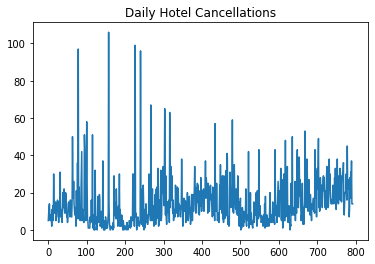

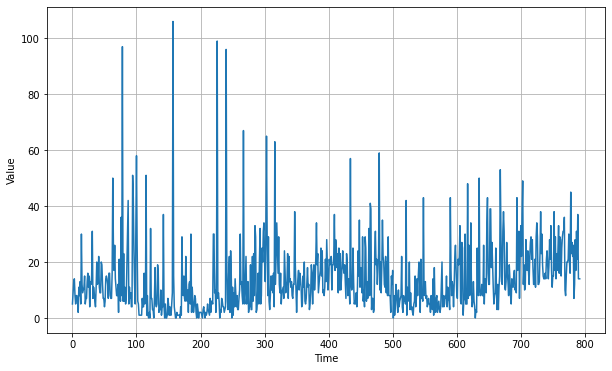

In [16]:
df = pd.read_csv("daily cancellations h1.csv", dtype=dtypes)
series = df['IsCanceled']
series=np.array(series)
plt.plot(series)
plt.title("Daily Hotel Cancellations")
plt.show()
time = np.arange(0, 793)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [17]:
#Train과 Valid데이터셋트 가르기 
split_time = 634
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [18]:
#1D-Conv Layer로 전처리 하기 
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)


In [19]:
#모델만들기

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=1,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
keras.layers.LSTM(32, return_sequences=True)
#keras.layers.Dense(1)
keras.layers.Dense(1, kernel_regularizer=keras.regularizers.l2(0.001))
keras.layers.Lambda(lambda x: x * 200)

optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h6", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


      4/Unknown - 3s 43ms/step - loss: 12.0144 - mae: 12.5010INFO:tensorflow:Assets written to: my_checkpoint.h6/assets
5/5 [==============================] - 6s 843ms/step - loss: 12.0271 - mae: 12.5135 - val_loss: 19.0889 - val_mae: 19.5889
Epoch 2/500
5/5 [==============================] - 33s 8s/step - loss: 11.7825 - mae: 12.2702 - val_loss: 18.7031 - val_mae: 19.2031
Epoch 3/500
5/5 [==============================] - 3s 656ms/step - loss: 11.5417 - mae: 12.0302 - val_loss: 18.3133 - val_mae: 18.8133
Epoch 4/500
5/5 [==============================] - 3s 751ms/step - loss: 11.3087 - mae: 11.7949 - val_loss: 17.9037 - val_mae: 18.4037
Epoch 5/500
5/5 [==============================] - 3s 700ms/step - loss: 11.0691 - mae: 11.5562 - val_loss: 17.4652 - val_mae: 17.9652
Epoch 6/500
5/5 [==============================] - 3s 679ms/step - loss: 10.8092 - mae: 11.2954 - val_loss: 16.9192 - val_mae: 17.4192
Epoch 7/500
5/5 [==============================] - 3s 778ms/step - loss: 10.4974 - m

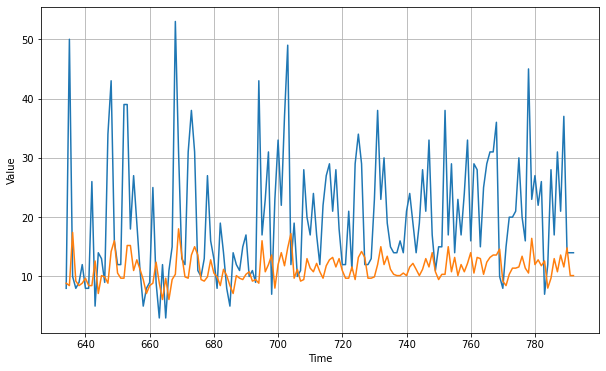

In [20]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

과제

Kernel Size를 5로 바꾸기
L2가중치 규제 해보기
LSM레이어의 Hidden Unit Size를 64개로 늘려보기 굵은 텍스트

#Kernel size 
keras.layers.Conv1D(filters=32,
                          kernel_size=5,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")

#L2규제
keras.layers.Dense(1, kernel_regularizer=keras.regularizers.l2(0.001))

#hidden unit size 
keras.layers.LSTM(64, return_sequences=True)

In [21]:
#모델만들기

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=5,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
keras.layers.LSTM(64, return_sequences=True)
#keras.layers.Dense(1)
keras.layers.Dense(1, kernel_regularizer=keras.regularizers.l2(0.001))
keras.layers.Lambda(lambda x: x * 200)

optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h6", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


      4/Unknown - 2s 92ms/step - loss: 11.7167 - mae: 12.2045INFO:tensorflow:Assets written to: my_checkpoint.h6/assets
5/5 [==============================] - 6s 979ms/step - loss: 11.7446 - mae: 12.2325 - val_loss: 18.6297 - val_mae: 19.1297
Epoch 2/500
5/5 [==============================] - 3s 752ms/step - loss: 11.3135 - mae: 11.8006 - val_loss: 17.7229 - val_mae: 18.2229
Epoch 3/500
5/5 [==============================] - 4s 888ms/step - loss: 10.6916 - mae: 11.1761 - val_loss: 16.2131 - val_mae: 16.7121
Epoch 4/500
5/5 [==============================] - 6s 1s/step - loss: 9.8987 - mae: 10.3821 - val_loss: 13.9050 - val_mae: 14.3997
Epoch 5/500
5/5 [==============================] - 3s 725ms/step - loss: 9.2820 - mae: 9.7654 - val_loss: 11.7571 - val_mae: 12.2478
Epoch 6/500
5/5 [==============================] - 4s 839ms/step - loss: 9.1668 - mae: 9.6524 - val_loss: 10.9748 - val_mae: 11.4654
Epoch 7/500
5/5 [==============================] - 3s 748ms/step - loss: 9.0293 - mae: 9.5

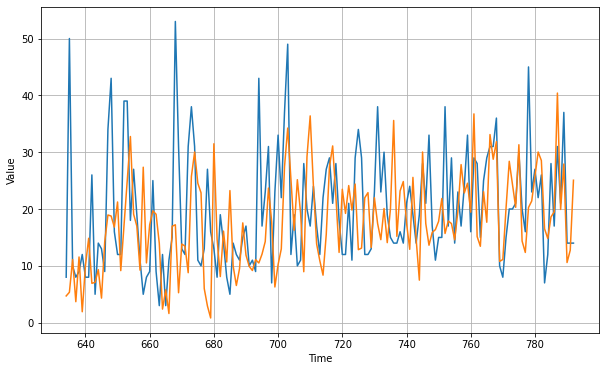

In [22]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)